In [0]:
! pip install py2neo
! pip install wikipedia

In [0]:
import wikipedia
import networkx as nx

### Collecting data and creating graph

In [0]:
links = []
def is_here(l):
    k = (l[1], l[0])
    for elem in links:
        if l == elem or k == elem:
            return 0
    return 1


def search(str, f):
    if f < 15:
        a = str.split()
        near = wikipedia.search(a)
        for elem in near:
            if is_here((elem, str)):    
                links.append((str, elem))
                search(elem, f + 1)
    
search('Lermontov', 0)

Кол-во вершин 2023
Кол-во ребер 5482


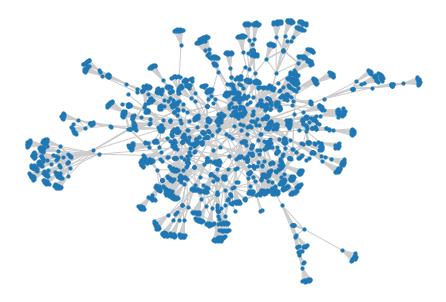

In [7]:
g = nx.Graph()
g.add_edges_from(links)
print("Кол-во вершин", g.number_of_nodes())
print("Кол-во ребер", g.number_of_edges())
nx.draw(g, node_size=10, edge_color='0.8')

### Moving data to the database

In [0]:
from py2neo import Node, Relationship, Graph

In [0]:
# the database is hosted on a neo4j sandbox
NEO4J_HOST = 'bolt://3.84.239.221:43153'
NEO4J_AUTH = ("neo4j", "housing-colds-bag")

graph = Graph(NEO4J_HOST, auth=NEO4J_AUTH)

In [0]:
LINKED = Relationship.type("LINKED")
for vertex, neighs in g.adj.items():
    for neigh in neighs:
        if vertex == neigh:
            continue
        v1 = Node('Article', name=vertex)
        v2 = Node('Article', name=neigh)
        graph.merge(LINKED(v1, v2), 'Article', 'name')

### Layout argorithm

In [0]:
from collections import defaultdict, deque
import math


class HierarchicalLayout(object):
    def __init__(self, graph):
        self.order = defaultdict(list)
        self.visited = set()
        self.bfs_stack = deque()
        self.positions = {}
        self.graph = graph

    def clear_variables(self):
        self.order = defaultdict(list)
        self.visited = set()
        self.bfs_stack = deque()
        self.positions = {}
    
    def __call__(self, root, default_algo='bfs', is_circular=False):  # returns layout
        self.clear_variables()
        self.is_circular = is_circular
        if default_algo == 'bfs':
            self.bfs(root, 0)
        elif default_algo == 'dfs':
            self.dfs(root, 0)
        else:
            raise NotImplementedError('Unknown algorithm: %s' % default_algo)
        self.find_positions()
        return self.positions

    def get_heighbours(self, node):
        return self.graph.adj[node]
    
    def bfs(self, node, layer):
        self.visited.add(node)
        self.order[layer].append(node)
        while self.bfs_stack or layer == 0:
            for neigh in self.get_heighbours(node):
                if neigh not in self.visited:
                    self.visited.add(neigh)
                    self.bfs_stack.append((neigh, layer + 1))
            node, layer = self.bfs_stack.popleft()
            self.order[layer].append(node)

    def dfs(self, node, layer):
        self.order[layer].append(node)
        self.visited.add(node)
        for neigh in self.get_heighbours(node):
            if neigh not in self.visited:
                self.dfs(neigh, layer + 1)

    def polar_to_cartesian(self, phi, r):
        return(r * math.cos(phi), r * math.sin(phi))
    
    def find_positions(self):
        num_layers = len(self.order)
        for layer in self.order:
            nodes_per_layer = len(self.order[layer])
            for i, node in enumerate(self.order[layer]):
                if not self.is_circular:
                    self.positions[node] = (i - nodes_per_layer // 2, num_layers - layer)
                else:
                    self.positions[node] = self.polar_to_cartesian(i / nodes_per_layer * math.pi * 2, layer)


class HierarchicalLayout_R(object): #в радиальных координатах
    def __init__(self, graph):
        self.order = defaultdict(list)
        self.visited = set()
        self.bfs_stack = deque()
        self.positions = {}
        self.graph = graph

    def clear_variables(self):
        self.order = defaultdict(list)
        self.visited = set()
        self.bfs_stack = deque()
        self.positions = {}
    
    def __call__(self, root, default_algo='bfs'):  # returns layout
        self.clear_variables()
        if default_algo == 'bfs':
            self.bfs(root, 0)
        elif default_algo == 'dfs':
            self.dfs(root, 0)
        else:
            raise NotImplementedError('Unknown algorithm: %s' % default_algo)
        self.find_positions()
        return self.positions

    def get_heighbours(self, node):
        return self.graph.adj[node]
    
    def bfs(self, node, layer):
        self.visited.add(node)
        self.order[layer].append(node)
        while self.bfs_stack or layer == 0:
            for neigh in self.get_heighbours(node):
                if neigh not in self.visited:
                    self.visited.add(neigh)
                    self.bfs_stack.append((neigh, layer + 1))
            node, layer = self.bfs_stack.popleft()
            self.order[layer].append(node)

    def dfs(self, node, layer):
        self.order[layer].append(node)
        self.visited.add(node)
        for neigh in self.get_heighbours(node):
            if neigh not in self.visited:
                self.dfs(neigh, layer + 1)
    
    def find_positions(self):
        num_layers = len(self.order)
        for layer in self.order:
            nodes_per_layer = len(self.order[layer])
            for i, node in enumerate(self.order[layer]):
                self.positions[node] = (i - nodes_per_layer // 2, num_layers - layer)
     


In [0]:
hl = HierarchicalLayout_R(g)
root = 'Google Talk'
pos = hl(root, default_algo='bfs', is_circular=True)

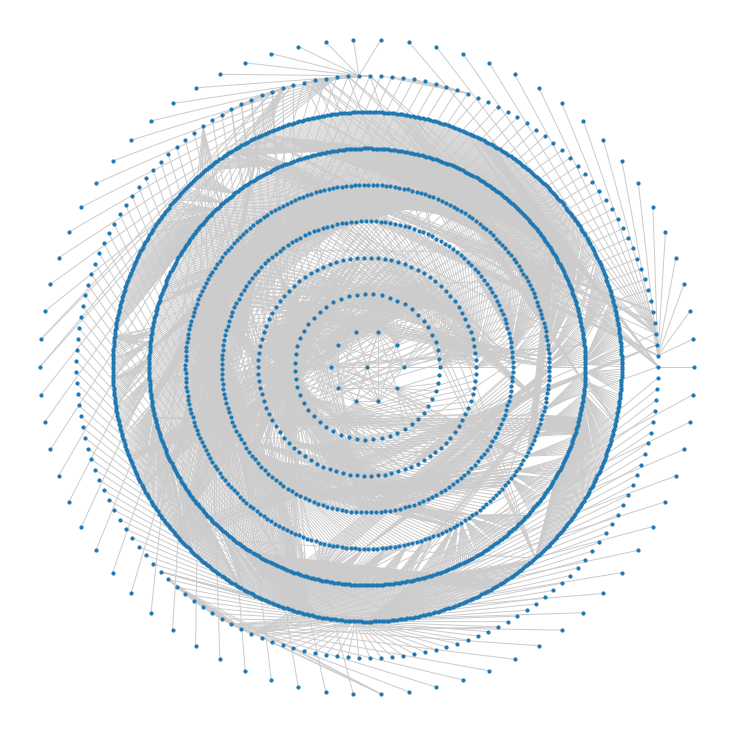

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10)) 
nx.draw(g, pos, node_size=10, edge_color='0.8', with_labels=False, font_size=4)